# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Data Exploration
- Load datasets.
- Visualize distributions, counts, and relationships between variables.
- Identify and handle missing values, outliers, and any anomalies.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# read in the json files
portfolio_df = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile_df = pd.read_json('data/profile.json', orient='records', lines=True)
transcript_df = pd.read_json('data/transcript.json', orient='records', lines=True)

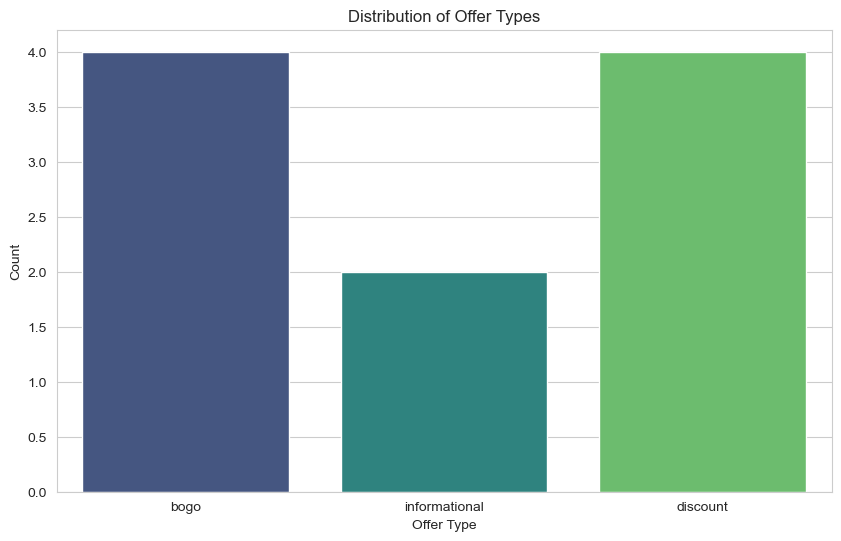

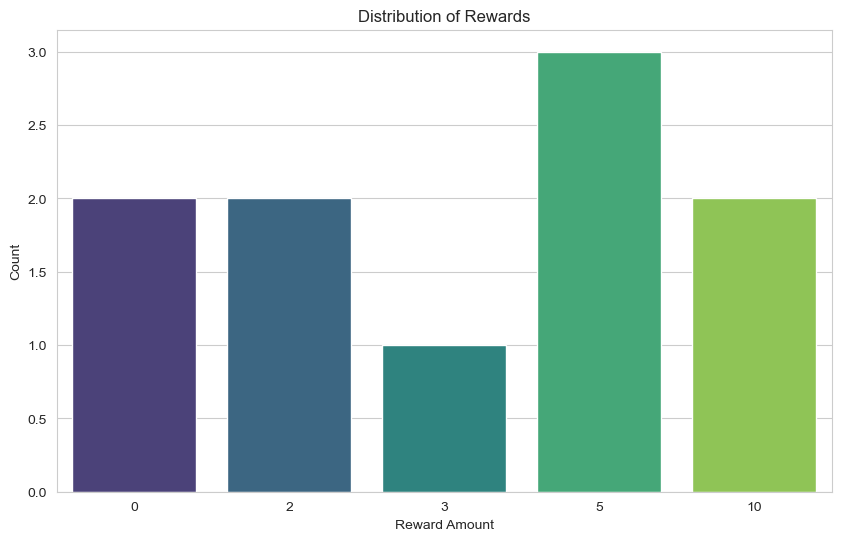

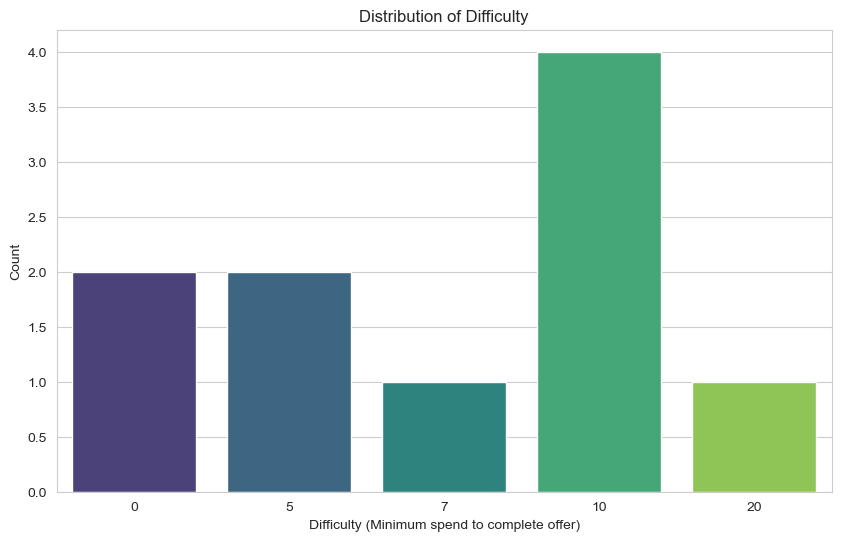

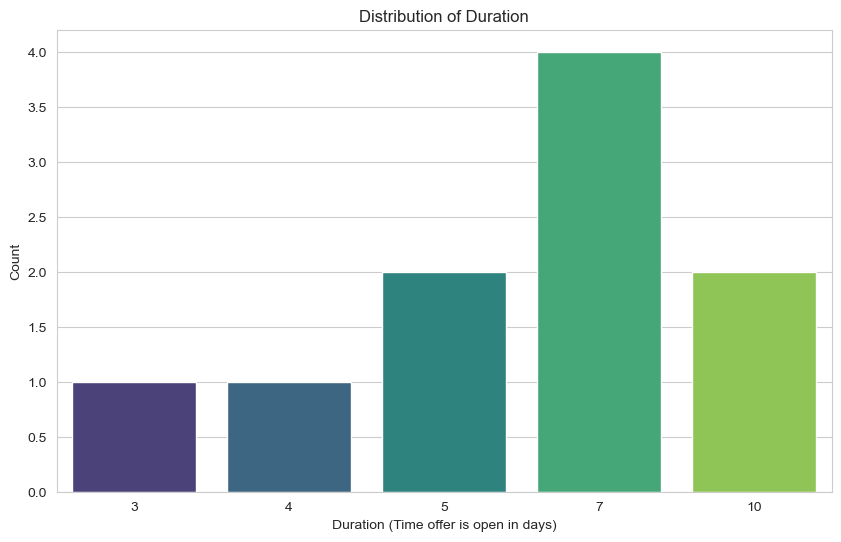

In [2]:
# Set the style for the plots
sns.set_style("whitegrid")

# Data Exploration for the portfolio dataset

# 1. Offer types distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=portfolio_df, x="offer_type", palette="viridis")
plt.title("Distribution of Offer Types")
plt.ylabel("Count")
plt.xlabel("Offer Type")
plt.show()

# 2. Distribution of Rewards
plt.figure(figsize=(10, 6))
sns.countplot(data=portfolio_df, x="reward", palette="viridis")
plt.title("Distribution of Rewards")
plt.ylabel("Count")
plt.xlabel("Reward Amount")
plt.show()

# 3. Distribution of Difficulty
plt.figure(figsize=(10, 6))
sns.countplot(data=portfolio_df, x="difficulty", palette="viridis")
plt.title("Distribution of Difficulty")
plt.ylabel("Count")
plt.xlabel("Difficulty (Minimum spend to complete offer)")
plt.show()

# 4. Distribution of Duration
plt.figure(figsize=(10, 6))
sns.countplot(data=portfolio_df, x="duration", palette="viridis")
plt.title("Distribution of Duration")
plt.ylabel("Count")
plt.xlabel("Duration (Time offer is open in days)")
plt.show()

The visualizations provide insights into the portfolio dataset:

1. Distribution of Offer Types:

    The dataset contains three types of offers: BOGO (Buy One Get One), Discount, and Informational.
    Both BOGO and Discount offers have similar counts, while Informational offers are fewer in number.
    
2. Distribution of Rewards:

    The rewards range from 0 to 10 units.
    There are offers with no rewards, which are likely the Informational offers.
    The most common reward amounts are 5 and 10 units.
    
3. Distribution of Difficulty:

    The difficulty (or minimum spend required to complete an offer) ranges from 0 to 20 units.
    As with rewards, offers with a difficulty of 0 are likely the Informational offers.
    The most common difficulties are set at 10 and 5 units.
    
4. Distribution of Duration:

    Offer durations range from 4 to 10 days.
    The most common duration is 7 days, followed by 10 days.

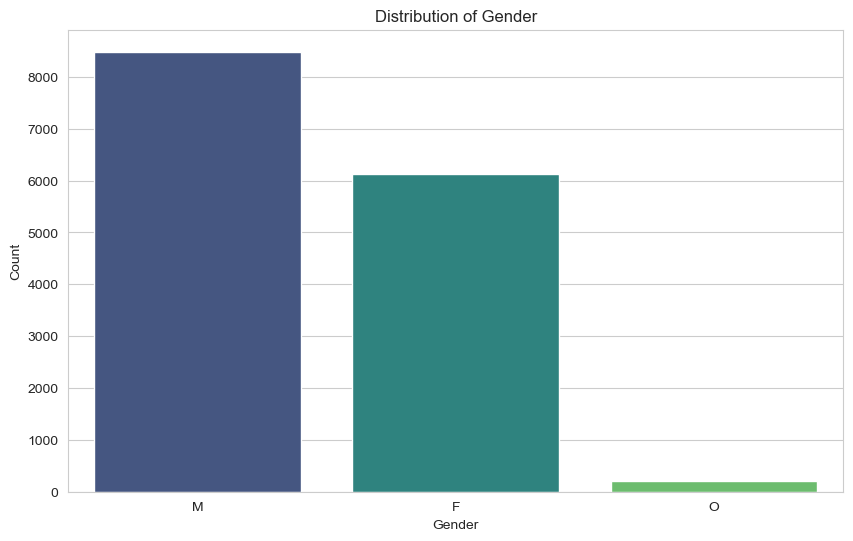

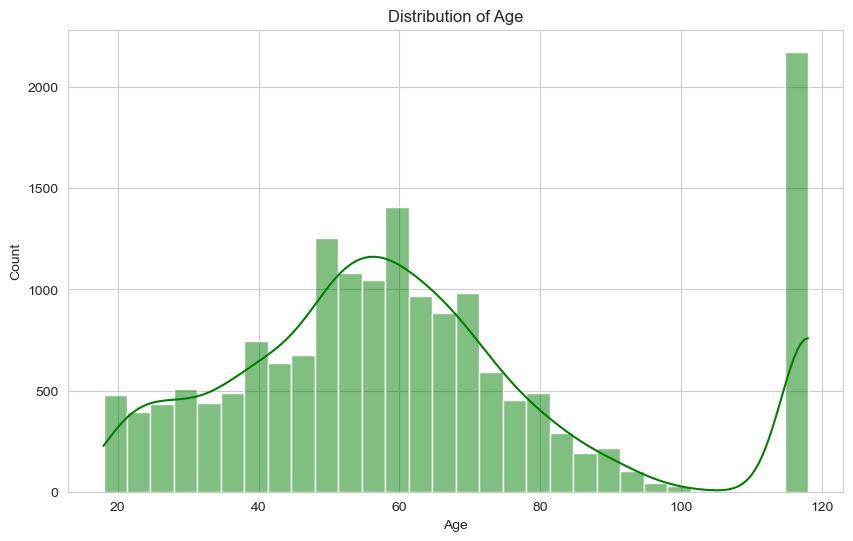

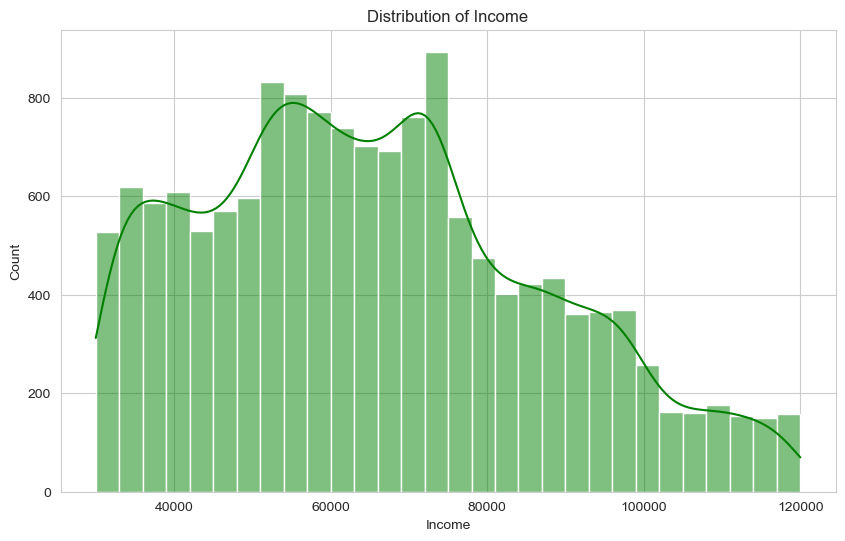

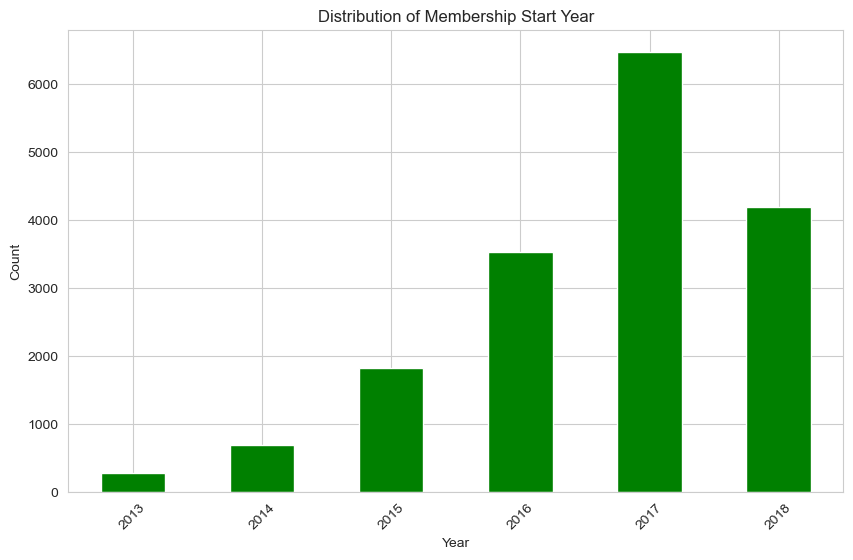

In [3]:
# Data Exploration for the profile dataset

# 1. Gender distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=profile_df, x="gender", palette="viridis", order=profile_df["gender"].value_counts().index)
plt.title("Distribution of Gender")
plt.ylabel("Count")
plt.xlabel("Gender")
plt.show()

# 2. Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(profile_df["age"], bins=30, kde=True, color="green")
plt.title("Distribution of Age")
plt.ylabel("Count")
plt.xlabel("Age")
plt.show()

# 3. Income distribution
plt.figure(figsize=(10, 6))
sns.histplot(profile_df["income"], bins=30, kde=True, color="green")
plt.title("Distribution of Income")
plt.ylabel("Count")
plt.xlabel("Income")
plt.show()

# 4. Membership start date distribution
# Convert 'became_member_on' from int to datetime
profile_df["became_member_on"] = pd.to_datetime(profile_df["became_member_on"], format="%Y%m%d")

plt.figure(figsize=(10, 6))
profile_df["became_member_on"].dt.year.value_counts().sort_index().plot(kind="bar", color="green")
plt.title("Distribution of Membership Start Year")
plt.ylabel("Count")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.show()


In [4]:
print("=====Check the null data in the profile dataset=====")

profile_df.isnull().sum()

=====Check the null data in the profile dataset=====


gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Here are the insights from the profile dataset visualizations:

1. Distribution of Gender:

The majority of customers in the dataset are male, followed by female and other.
There's a significant portion of customers with unspecified genders (2175 records) (represented as None).

2. Distribution of Age:

The age distribution has a wide range, with a peak around the early 60s.
There's a noticeable spike at age 118, which appears to be a placeholder or default value for unspecified ages. This will need to be addressed during data cleaning.

3. Distribution of Income:

Income distribution appears to be multimodal, with peaks around 30k, 50k and 70k USD. The number of null records of income is algined with gender column. This could be handled in cleaning phase.

4. Distribution of Membership Start Year:

A significant number of customers joined in 2017, followed by 2018.
Membership numbers have been growing since 2013.

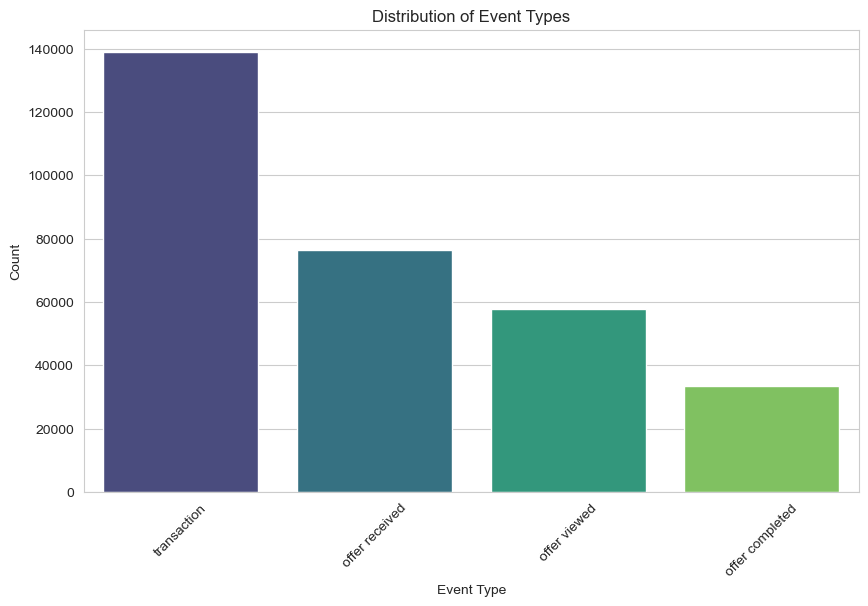

array(['offer id', 'amount', 'offer_id', 'reward'], dtype=object)

In [5]:
# Data Exploration for the transcript dataset

# 1. Distribution of Event Types
plt.figure(figsize=(10, 6))
sns.countplot(data=transcript_df, x="event", palette="viridis", order=transcript_df["event"].value_counts().index)
plt.title("Distribution of Event Types")
plt.ylabel("Count")
plt.xlabel("Event Type")
plt.xticks(rotation=45)
plt.show()

# 2. Exploration of 'value' column
# Let's extract the type of keys present in the 'value' dictionary to understand its structure
value_keys = transcript_df["value"].apply(lambda x: list(x.keys())).explode().unique()

value_keys


From the transcript dataset visualizations and exploration:

1. Distribution of Event Types:

The dataset contains four types of events: offer received, offer viewed, transaction, and offer completed.
The most common event is transaction, followed by offer received, offer viewed, and offer completed.

2. Exploration of the 'value' Column:

The value column contains dictionaries with different keys. We've identified four unique keys: offer id, amount, offer_id, and reward.
The presence of both offer id and offer_id suggests that there might be some inconsistency in the data, which we'll need to address during data cleaning.


# Data Cleaning and Preprocessing

- Handle missing values and placeholder values.
- Convert date columns to the appropriate format.
- Address inconsistencies, such as the offer id and offer_id keys in the transcript dataset.
- Transform categorical variables.

In [6]:
# Data Cleaning for the profile dataset

# 1. Handle placeholder values in the age column
# Replace age 118 with median of age (as it seems to be a placeholder for missing data)
median_age = profile_df[profile_df["age"] != 118]["age"].median()
profile_df["age"].replace(118, median_age, inplace=True)

#Fill missing value of age column with median age as well
profile_df["age"] = profile_df["age"].fillna(median_age)

# 2. Handle missing values in the gender and income columns
# Replace 'None' in gender with Others ("O")
profile_df["gender"].replace("None", "O", inplace=True)

#Fill missing value of gender with "Other" as a assumption
profile_df["gender"] = profile_df["gender"].fillna("O")

#Fill missing value of income with median income of the dataset
median_income = profile_df["income"].median()
profile_df["income"] = profile_df["income"].fillna(median_income)
        

In [7]:
#Check the null data
profile_df.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [8]:
profile_df.head()

,gender,age,id,became_member_on,income
0,O,55,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,O,55,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,64000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,O,55,a03223e636434f42ac4c3df47e8bac43,2017-08-04,64000.0


Next, we'll address the inconsistencies in the transcript dataset, specifically the value column having both offer id and offer_id keys.​

In [9]:
# Data Cleaning for the transcript dataset

# 1. Standardize the keys in the 'value' column
def standardize_keys(value_dict):
    if 'offer id' in value_dict:
        value_dict['offer_id'] = value_dict.pop('offer id')
    return value_dict

transcript_df["value"] = transcript_df["value"].apply(standardize_keys)

# Display the unique keys in the 'value' column after cleaning
value_keys_cleaned = transcript_df["value"].apply(lambda x: list(x.keys())).explode().unique()

value_keys_cleaned


array(['offer_id', 'amount', 'reward'], dtype=object)

The inconsistencies in the transcript dataset's value column have been addressed. The keys are now standardized to offer_id, amount, and reward.

Next, we'll preprocess the portfolio dataset, mainly focusing on transforming the categorical variable offer_type using one-hot encoding and expanding the channels list into separate binary columns for each channel.

In [10]:
# Data Preprocessing for the portfolio dataset

# 1. One-hot encode the 'offer_type' column
offer_type_encoded = pd.get_dummies(portfolio_df["offer_type"], prefix="offer_type")

# 2. Expand the 'channels' list into separate binary columns for each channel
channels_encoded = portfolio_df["channels"].apply(lambda x: pd.Series([1 if channel in x else 0 for channel in ["web", "email", "mobile", "social"]], 
                                                  index=["web", "email", "mobile", "social"]))

# 3. Concatenate the one-hot encoded columns with the original dataframe and drop the original 'offer_type' and 'channels' columns
portfolio_preprocessed = pd.concat([portfolio_df, offer_type_encoded, channels_encoded], axis=1).drop(columns=["offer_type", "channels"])

# Display the first few rows of the preprocessed portfolio DataFrame
portfolio_preprocessed.head()


,reward,difficulty,duration,id,offer_type_bogo,offer_type_discount,offer_type_informational,web,email,mobile,social
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,0,1,1,1
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,1,0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,1,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,1,0,0


The portfolio dataset has been preprocessed.

The offer_type column has been one-hot encoded, resulting in separate columns for each offer type (BOGO, discount, and informational).
The channels list column has been expanded into separate binary columns for each channel (web, email, mobile, and social).

In [11]:
# Extract the offer_id and amount from the 'value' column in the transcript dataframe
transcript_df["offer_id"] = transcript_df["value"].apply(lambda x: x.get("offer_id"))
transcript_df["amount"] = transcript_df["value"].apply(lambda x: x.get("amount", 0))

transcript_df.drop(columns=["value"], inplace=True)
transcript_df.head()

,person,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


# Feature Engineering and Selection

- Combine the datasets to create a comprehensive view of customer-offer interactions.
- Generate new features that may be valuable for predictive modeling.
- Select relevant features for modeling.

In [12]:
# Merge the transcript dataset with the profile dataset based on the customer ID
merged_df = pd.merge(transcript_df, profile_df, left_on="person", right_on="id", how="left").drop(columns="id")

# Merge the resulting dataframe with the portfolio_preprocessed dataset based on the offer ID
merged_df = pd.merge(merged_df, portfolio_preprocessed, left_on="offer_id", right_on="id", how="left").drop(columns="id")

# Display the first few rows of the merged DataFrame
merged_df.head()


,person,event,time,offer_id,amount,gender,age,became_member_on,income,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,F,75,2017-05-09,100000.0,5.0,5.0,7.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,O,55,2017-08-04,64000.0,5.0,20.0,10.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,M,68,2018-04-26,70000.0,2.0,10.0,7.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,O,55,2017-09-25,64000.0,2.0,10.0,10.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,O,55,2017-10-02,64000.0,10.0,10.0,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0


The datasets have been successfully merged into a unified dataframe, capturing customer-offer interactions. The merged dataframe contains:

- Customer details like gender, age, income, and membership start date.
- Transcript events like event, time, amount, and offer_id.
- Offer details like reward, difficulty, duration, offer type, and channels.

With the merged dataframe in place, we can now proceed with feature engineering to generate new features that could be valuable for predictive modeling.

In [13]:
# Feature Engineering for the merged dataframe

# 1. Calculate Membership Duration
current_date = pd.Timestamp.now()
merged_df["membership_duration"] = (current_date - merged_df["became_member_on"]).dt.days

# 2. Event Type Encoding
event_encoded = pd.get_dummies(merged_df["event"], prefix="event")
merged_df = pd.concat([merged_df, event_encoded], axis=1)

# Display the first few rows of the dataframe after feature engineering
merged_df.head()


,person,event,time,offer_id,amount,gender,age,became_member_on,income,reward,...,offer_type_informational,web,email,mobile,social,membership_duration,event_offer completed,event_offer received,event_offer viewed,event_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,F,75,2017-05-09,100000.0,5.0,...,0.0,1.0,1.0,1.0,0.0,2372,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,O,55,2017-08-04,64000.0,5.0,...,0.0,1.0,1.0,0.0,0.0,2285,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,M,68,2018-04-26,70000.0,2.0,...,0.0,1.0,1.0,1.0,0.0,2020,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,O,55,2017-09-25,64000.0,2.0,...,0.0,1.0,1.0,1.0,1.0,2233,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,O,55,2017-10-02,64000.0,10.0,...,0.0,1.0,1.0,1.0,1.0,2226,0,1,0,0


The merged dataframe has been enhanced with new features:

- Membership Duration: The duration (in days) since the customer became a member up to the current date.
- Event Type Encoding: The event column has been transformed into separate binary columns for each event type (event_offer completed, event_offer received, event_offer viewed, and event_transaction).

In [81]:
#Check all columns name
merged_df.columns

Index(['event_offer_received', 'event_offer_completed', 'event_offer_viewed',
       'time', 'age', 'income', 'difficulty', 'duration', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'web', 'email',
       'mobile', 'social', 'membership_duration', 'response',
       'difficulty_income_interaction', 'gender_F', 'gender_M', 'gender_O',
       'year_become_member', 'month_become_member', 'date_become_member'],
      dtype='object')

In [15]:
# Rename some columns for better processing later
merged_df.rename(columns={"event_offer completed": "event_offer_completed", "event_offer received": "event_offer_received", "event_offer viewed": "event_offer_viewed"}, errors="raise", inplace=True)

In [16]:
#Transform the unified dataframe in order to make the target variable 
merged_df = merged_df.groupby(['person','offer_id'], as_index=False).agg({'event_offer_received':'sum',
                                                              'event_offer_completed':'sum', 
                                                              'event_offer_viewed':'sum',
                                                              'time': 'first',
                                                              'gender': 'first',
                                                              'age': 'first', 
                                                              'became_member_on': 'first', 
                                                              'income': 'first', 
                                                              'difficulty': 'first', 
                                                              'duration': 'first',
                                                              'offer_type_bogo': 'first', 
                                                              'offer_type_discount': 'first', 
                                                              'offer_type_informational': 'first',
                                                              'web': 'first',
                                                              'email': 'first',
                                                              'mobile': 'first', 
                                                              'social': 'first', 
                                                              'membership_duration': 'first'})

In [17]:
# Define the target variable as 1 if both event_offer_viewed and event_offer_completed are 1, else 0
merged_df['response'] = ((merged_df['event_offer_viewed'] == 1) & (merged_df['event_offer_completed'] == 1)).astype(int)
merged_df

,person,offer_id,event_offer_received,event_offer_completed,event_offer_viewed,time,gender,age,became_member_on,income,...,duration,offer_type_bogo,offer_type_discount,offer_type_informational,web,email,mobile,social,membership_duration,response
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,576,M,33,2017-04-21,72000.0,...,7.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,2390,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0,1,336,M,33,2017-04-21,72000.0,...,4.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,2390,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0,1,168,M,33,2017-04-21,72000.0,...,3.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,2390,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,408,M,33,2017-04-21,72000.0,...,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2390,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,504,M,33,2017-04-21,72000.0,...,10.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2390,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,2,2,0,M,34,2017-01-23,34000.0,...,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2478,0
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,168,F,45,2016-11-25,62000.0,...,10.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2537,1
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,3,3,336,F,45,2016-11-25,62000.0,...,7.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,2537,0
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,504,F,45,2016-11-25,62000.0,...,7.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2537,1


In [18]:
# For feature engineering, let's create a new feature that combines the 'difficulty' and 'income' as an interaction term
merged_df['difficulty_income_interaction'] = merged_df['difficulty'] * merged_df['income']

# Gender Encoding
gender_encoded = pd.get_dummies(merged_df["gender"], prefix="gender")
merged_df = pd.concat([merged_df, gender_encoded], axis=1)

In [19]:
#Featuring year, month, date from became member on column

merged_df['year_become_member'] = merged_df['became_member_on'].dt.year
merged_df['month_become_member'] = merged_df['became_member_on'].dt.month
merged_df['date_become_member'] = merged_df['became_member_on'].dt.day

In [21]:
#Check the final columns name
merged_df.columns

Index(['person', 'offer_id', 'event_offer_received', 'event_offer_completed',
       'event_offer_viewed', 'time', 'gender', 'age', 'became_member_on',
       'income', 'difficulty', 'duration', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'web', 'email',
       'mobile', 'social', 'membership_duration', 'response',
       'difficulty_income_interaction', 'gender_F', 'gender_M', 'gender_O',
       'year_become_member', 'month_become_member', 'date_become_member'],
      dtype='object')

In [22]:
# Drop non-needed columns 
merged_df.drop(['person', 'offer_id', 'gender', 'became_member_on'], axis=1, inplace=True)

# Implementation

In [23]:
# Define features and target variable
X = merged_df.drop(columns=['response'])  # excluding 'email' as it has only one unique value
y = merged_df['response']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the balance of the target variable after SMOTE
balanced_response = y_train_smote.value_counts(normalize=True)

balanced_response


1    0.5
0    0.5
Name: response, dtype: float64

In [24]:
# Initialize the Logistic Regression model with class_weight='balanced' to handle the class imbalance
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Train the model on the training set without SMOTE (as SMOTE is not available)
lr_model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Calculate evaluation metrics
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])

f1, accuracy, roc_auc

(0.4984815618221258, 0.634697424553642, 0.6725916043304604)

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier with class_weight='balanced'
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

# Train the Random Forest model on the training set
rf_model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculate evaluation metrics for the Random Forest model
f1_rf = f1_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

f1_rf, accuracy_rf, roc_auc_rf

(0.9998711506249194, 0.9999209985779745, 1.0)

In [26]:
# Investigate feature importances from the Random Forest model
feature_importances = rf_model.feature_importances_

# Create a dataframe to view feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
1,event_offer_completed,0.466408
2,event_offer_viewed,0.201200
0,event_offer_received,0.091092
16,difficulty_income_interaction,0.035085
7,duration,0.032132
10,offer_type_informational,0.031170
14,social,0.023225
6,difficulty,0.022171
19,gender_O,0.017042
20,year_become_member,0.011834


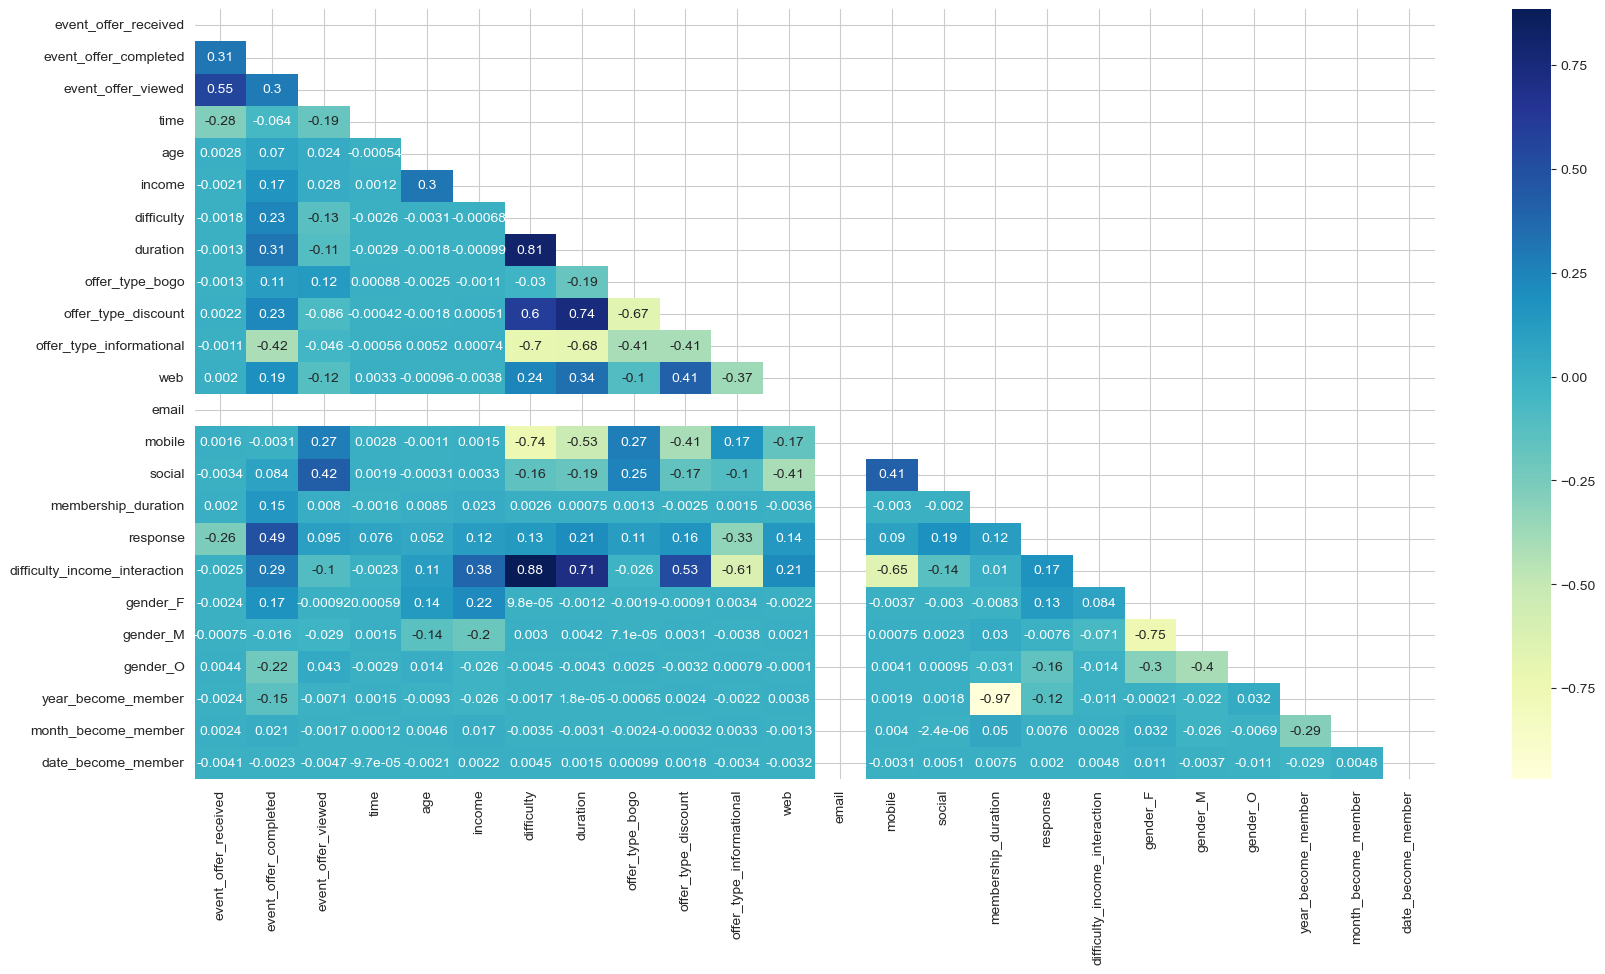

In [27]:
# creating mask
mask = np.triu(np.ones_like(merged_df.corr()))
 
# plotting a triangle correlation heatmap
fig, axs = plt.subplots(figsize=(20, 10))
dataplot = sns.heatmap(merged_df.corr(), cmap="YlGnBu", annot=True, mask=mask)

In [28]:
# Drop the 'event_offer_completed' feature to prevent data leakage
X_train_no_leakage = X_train_smote.drop(columns=['event_offer_completed'])
X_test_no_leakage = X_test.drop(columns=['event_offer_completed'])

In [29]:
# Retrain the Random Forest classifier without the leakage features
rf_model.fit(X_train_no_leakage, y_train_smote)

# Make predictions on the test set without the leakage features
y_pred_rf_no_leakage = rf_model.predict(X_test_no_leakage)

# Calculate evaluation metrics for the Random Forest model without the leakage features
f1_rf_no_leakage = f1_score(y_test, y_pred_rf_no_leakage)
accuracy_rf_no_leakage = accuracy_score(y_test, y_pred_rf_no_leakage)
roc_auc_rf_no_leakage = roc_auc_score(y_test, rf_model.predict_proba(X_test_no_leakage)[:, 1])

f1_rf_no_leakage, accuracy_rf_no_leakage, roc_auc_rf_no_leakage

(0.7803726708074534, 0.8603254858587455, 0.9411950379668441)

In [30]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Hyperparameter grid
param_dist = {
    'n_estimators': np.arange(100, 501, 100),
    'max_depth': [None] + list(np.arange(5, 26, 5)),
    'min_samples_split': np.arange(2, 11, 2),
    'min_samples_leaf': np.arange(1, 11, 2),
    'max_features': ['auto', 'log2', None]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,  # number of parameter settings that are sampled
    scoring='f1',
    n_jobs=-1,
    cv=5,
    random_state=42
)

# Perform the random search on the data
random_search.fit(X_train_no_leakage, y_train_smote)

# Best model after random search
best_rf_model = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_best_rf = best_rf_model.predict(X_test_no_leakage)

# Calculate evaluation metrics for the best Random Forest model
f1_best_rf = f1_score(y_test, y_pred_best_rf)
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
roc_auc_best_rf = roc_auc_score(y_test, best_rf_model.predict_proba(X_test_no_leakage)[:, 1])

# Output the best hyperparameters and the corresponding metrics
random_search.best_params_, f1_best_rf, accuracy_best_rf, roc_auc_best_rf


/Users/pntk/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/pntk/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/pntk/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

({'n_estimators': 100,
  'min_samples_split': 4,
  'min_samples_leaf': 1,
  'max_features': 'auto',
  'max_depth': 15},
 0.799810919404396,
 0.8661715910886396,
 0.9473598411110391)

In [31]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Train
xgb_model.fit(X_train_no_leakage, y_train_smote)

# Predict
y_pred_xgb = xgb_model.predict(X_test_no_leakage)

# Calculate evaluation metricc
f1_xgb = f1_score(y_test, y_pred_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test_no_leakage)[:, 1])

f1_xgb, accuracy_xgb, roc_auc_xgb

(0.793947595030139, 0.8676726181071259, 0.9468607590574051)

In [32]:
# Define our search space for random search
param_dist_xgb = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0.5, 1, 2, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [100, 200, 300, 400, 500],
}

# Initialize XGBClassifier
xgb_clf = xgb.XGBClassifier()

# Initialize the Random Search Model
random_search_xgb = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_dist_xgb, n_iter=25, scoring='f1', cv=3, verbose=1)

# Perform the random search on the data
random_search_xgb.fit(X_train_no_leakage, y_train_smote)

# Best model after random search
best_xgb_model = random_search_xgb.best_estimator_

# Make predictions on the test set using the best model
y_pred_best_xgb = best_xgb_model.predict(X_test_no_leakage)

# Calculate evaluation metrics for the best Random Forest model
f1_best_xgb = f1_score(y_test, y_pred_best_xgb)
accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)
roc_auc_best_xgb = roc_auc_score(y_test, best_xgb_model.predict_proba(X_test_no_leakage)[:, 1])

# Output the best hyperparameters and the corresponding metrics
random_search.best_params_, f1_best_xgb, accuracy_best_xgb, roc_auc_best_xgb


Fitting 3 folds for each of 25 candidates, totalling 75 fits


({'n_estimators': 100,
  'min_samples_split': 4,
  'min_samples_leaf': 1,
  'max_features': 'auto',
  'max_depth': 15},
 0.799810919404396,
 0.8661715910886396,
 0.9473598411110391)

# Appendix 

Try to apply a random customer information to predict the probability of responding offers 

In [67]:
# Define the column names based on the provided information
column_info = {
    'event_offer_received': np.uint8,
    'event_offer_viewed': np.uint8,
    'time': np.int64,
    'age': np.int64,
    'income': np.float64,
    'difficulty': np.float64,
    'duration': np.float64,
    'offer_type_bogo': np.float64,
    'offer_type_discount': np.float64,
    'offer_type_informational': np.float64,
    'web': np.float64,
    'email': np.float64,
    'mobile': np.float64,
    'social': np.float64,
    'membership_duration': np.int64,
    'difficulty_income_interaction': np.float64,
    'gender_F': np.uint8,
    'gender_M': np.uint8,
    'gender_O': np.uint8,
    'year_become_member': np.int64,
    'month_become_member': np.int64,
    'date_become_member': np.int64
}

# Create a new dataframe with some example rows
new_data_example = pd.DataFrame({
    'event_offer_received': [1, 1],
    'event_offer_viewed': [1, 1],
    'time': [10, 10],
    'age': [25, 40],
    'income': [50000.0, 85000.0],
    'difficulty': [5.0, 10.0],
    'duration': [7.0, 10.0],
    'offer_type_bogo': [1.0, 1.0],
    'offer_type_discount': [1.0, 1.0],
    'offer_type_informational': [0.0, 0.0],
    'web': [1.0, 1.0],
    'email': [1.0, 1.0],
    'mobile': [1.0, 1.0],
    'social': [1.0, 0.0],
    'membership_duration': [1000, 365],
    'difficulty_income_interaction': [500.0, 900.0],
    'gender_F': [0, 1],
    'gender_M': [1, 0],
    'gender_O': [0, 0],
    'year_become_member': [2014, 2018],
    'month_become_member': [2, 11],
    'date_become_member': [15, 22]
}, dtype=object)

# Convert data types according to the column info
for col, dtype in column_info.items():
    new_data_example[col] = new_data_example[col].astype(dtype)

new_data_example

,event_offer_received,event_offer_viewed,time,age,income,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,...,mobile,social,membership_duration,difficulty_income_interaction,gender_F,gender_M,gender_O,year_become_member,month_become_member,date_become_member
0,1,1,10,25,50000.0,5.0,7.0,1.0,1.0,0.0,...,1.0,1.0,1000,500.0,0,1,0,2014,2,15
1,1,1,10,40,85000.0,10.0,10.0,1.0,1.0,0.0,...,1.0,0.0,365,900.0,1,0,0,2018,11,22


In [68]:
# Assuming 'new_data' is your new data after preprocessing from 2 customer with features, try to preidct either these cusotmer
# to complete the offer or not
y_pred_new_data = best_rf_model.predict(new_data_example)
y_pred_new_data

array([1, 0])

In [69]:
# The propability that test customer that use the bogo offer
prob_predictions_new_data = best_rf_model.predict_proba(new_data_example)
prob_predictions_new_data
confidence_levels = prob_predictions_new_data[:, 1]
confidence_levels

array([0.6476866 , 0.44425041])

In [42]:
import shap
# Fits the explainer
explainer = shap.Explainer(best_xgb_model.predict, X_test_no_leakage)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_no_leakage)

PermutationExplainer explainer: 12659it [42:10,  4.98it/s]                           


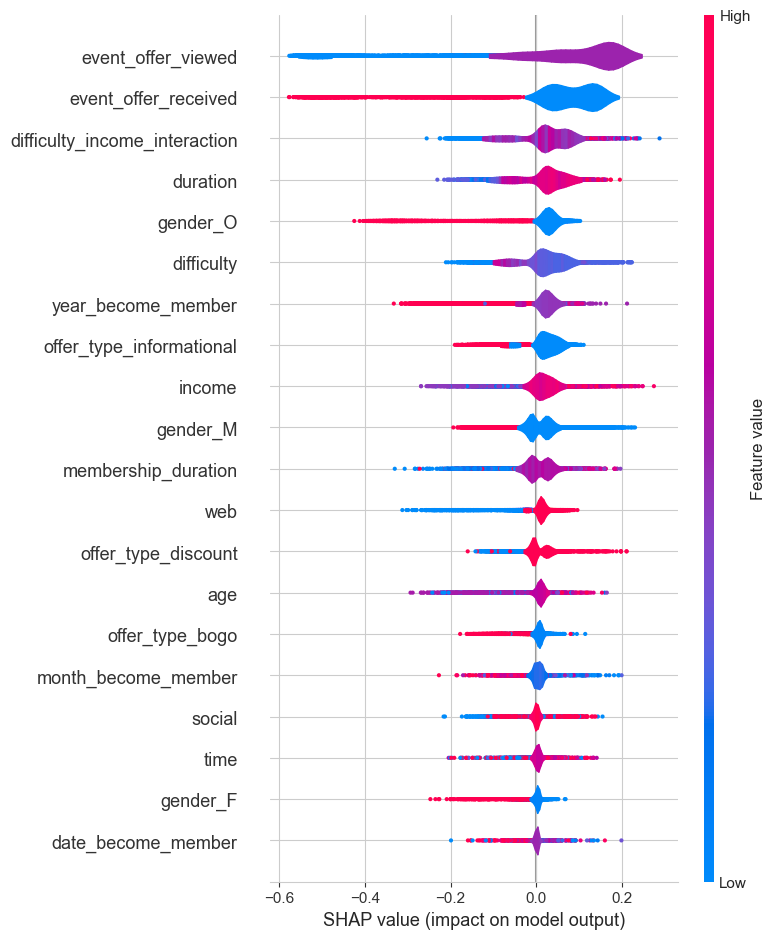

In [49]:
shap.summary_plot(shap_values, plot_type='violin')

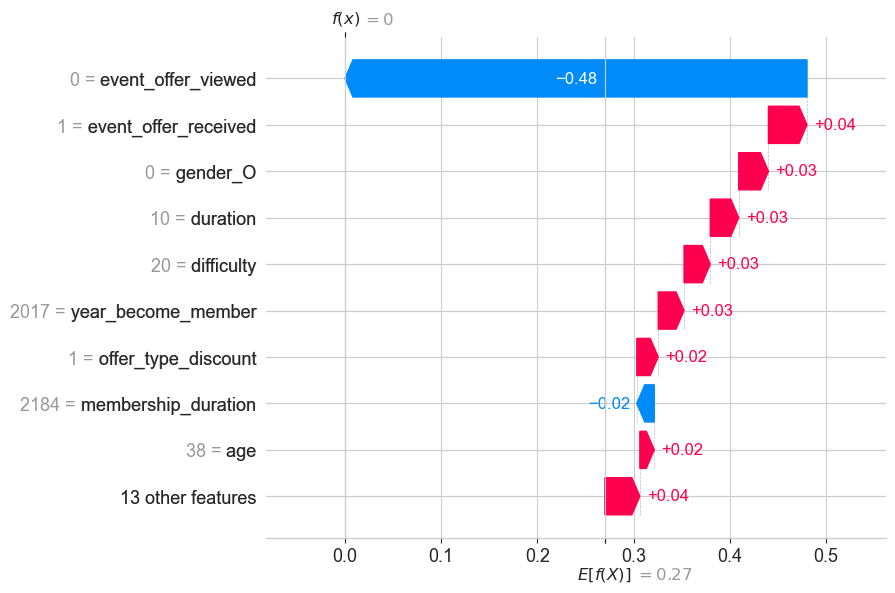

In [84]:
shap.plots.waterfall(shap_values[600])